# Generador de rostros artificiales mediante redes adversativas

En una red adversaria se tienen dos modelos (que pueden ser Redes Neuronales o Convolucionales) compitiendo: un Generador y un Discriminador.

Se genera un primer modelo que llamaremos Discriminador para que sea capaz de reconocer rostros humanos. Este discriminador será simplemente un clasificador,que buscara indicar si una imagen es real o falsa

Se genera un segundo modelo, que llamaremos Generador y nuestro objetivo es entrenarlo para que sea capaz de tomar una entrada aleatoria y a la salida generar algo muy parecido a una imagen de un rostro.

La idea es entrenar esos dos modelos simultáneamente buscando que al final sea el Generador el vencedor en esta competencia.



In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from imageio import imread

### Carga de datos

In [2]:
def cargar_datos(dataset):
    print('Creando set de entrenamiento...',end="",flush=True)
    filelist = os.listdir(dataset)

    n_imgs = len(filelist)
    x_train = np.zeros((n_imgs,128,128,3))

    for i, fname in enumerate(filelist):
        if fname != '.DS_Store':
            imagen = imread(os.path.join(dataset,fname))
            x_train[i,:] = (imagen - 127.5)/127.5
    print('¡Listo!')

    return x_train

x_train = cargar_datos("dataset1")

Creando set de entrenamiento...

c:\users\ignacio.milesi\desktop\proyectos\aml\tensorflow\tf-gpu\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  # Remove the CWD from sys.path while we load stuff.


¡Listo!


In [3]:
def visualizar_imagen(nimagen,x_train):
    imagen = (x_train[nimagen,:]*127.5) + 127.5
    imagen = np.ndarray.astype(imagen, np.uint8)
    plt.imshow(imagen.reshape(128,128,3))
    plt.axis('off')
    plt.show()

#visualizar_imagen(4,x_train)

### Creacion de los modelos

In [4]:
from keras.models import Sequential, Model
from keras.layers import Dense, Reshape, Conv2DTranspose, BatchNormalization, Conv2D, LeakyReLU, Flatten, Input
from keras.layers.core import Activation

In [6]:
def crear_generador(TAM_ENTRADA, LEAKY_SLOPE):
    modelo = Sequential()
    modelo.add(Dense(1024*4*4, use_bias=False, input_shape=(TAM_ENTRADA,)))
    
    modelo.add(BatchNormalization(momentum=0.3))
    modelo.add(LeakyReLU(alpha=LEAKY_SLOPE))
    modelo.add(Reshape((4,4,1024)))
    #Tamaño resultante: 4x4x1024

    modelo.add(Conv2DTranspose(512,(5,5),strides=(2,2),padding='same', use_bias=False))
    modelo.add(BatchNormalization(momentum=0.3))
    modelo.add(LeakyReLU(alpha=LEAKY_SLOPE))
    #Tamaño resultante: 8x8x512

    modelo.add(Conv2DTranspose(256,(5,5),strides=(2,2),padding='same', use_bias=False))
    modelo.add(BatchNormalization(momentum=0.3))
    modelo.add(LeakyReLU(alpha=LEAKY_SLOPE))
    #Tamaño resultante: 16x16x256

    modelo.add(Conv2DTranspose(128,(5,5),strides=(2,2),padding='same', use_bias=False))
    modelo.add(BatchNormalization(momentum=0.3))
    modelo.add(LeakyReLU(alpha=LEAKY_SLOPE))
    #Tamaño resultante: 32x32x128

    modelo.add(Conv2DTranspose(64,(5,5),strides=(2,2),padding='same', use_bias=False))
    modelo.add(BatchNormalization(momentum=0.3))
    modelo.add(LeakyReLU(alpha=LEAKY_SLOPE))
    #Tamaño resultante: 64x64x64
    
    modelo.add(Conv2DTranspose(3, (5,5),strides=(2,2),padding='same', use_bias=False))
    modelo.add(Activation('tanh'))
    #128x128x3

    modelo.compile(optimizer="Adam", loss="binary_crossentropy")

    return modelo

generador = crear_generador(100, 0.2)
generador.summary()

InternalError: failed to get compute capability major for device: UNKNOWN ERROR (1); 0

In [7]:
def crear_discriminador(LEAKY_SLOPE):
    modelo = Sequential(name = "Discriminador")
    modelo.add(Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=(128,128,3), use_bias=False))
    modelo.add(LeakyReLU(alpha=LEAKY_SLOPE))
    #64x64x64

    modelo.add(Conv2D(128, (5,5), strides=(2,2), padding='same', use_bias=False))
    modelo.add(BatchNormalization(momentum=0.3))
    modelo.add(LeakyReLU(alpha=LEAKY_SLOPE))
    #32x32x128

    modelo.add(Conv2D(256, (5,5), strides=(2,2), padding='same', use_bias=False))
    modelo.add(BatchNormalization(momentum=0.3))
    modelo.add(LeakyReLU(alpha=LEAKY_SLOPE))
    #16x16x256

    modelo.add(Conv2D(512, (5,5), strides=(2,2), padding='same', use_bias=False))
    modelo.add(BatchNormalization(momentum=0.3))
    modelo.add(LeakyReLU(alpha=LEAKY_SLOPE))
    #8x8x512

    modelo.add(Conv2D(1024, (5,5), strides=(2,2), padding='same', use_bias=False))
    modelo.add(BatchNormalization(momentum=0.3))
    modelo.add(LeakyReLU(alpha=LEAKY_SLOPE))
    #4x4x1024

    modelo.add(Flatten())
    modelo.add(Dense(1, activation='sigmoid', use_bias=False))

    modelo.compile(optimizer="Adam", loss="binary_crossentropy")

    return modelo

discriminador = crear_discriminador(0.2)
discriminador.summary()

InternalError: failed to get compute capability major for device: UNKNOWN ERROR (1); 0

In [7]:
def crear_GAN(generador, discriminador):
    modelo = Sequential(name = "GAN")
    modelo.add(generador)
    discriminador.trainable = False
    modelo.add(discriminador)
    modelo.compile(optimizer="Adam", loss="binary_crossentropy")

    return modelo

gan = crear_GAN(generador, discriminador)

gan.summary()

Model: "GAN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Generador (Sequential)       (None, 128, 128, 3)       19120576  
_________________________________________________________________
Discriminador (Sequential)   (None, 1)                 17436864  
Total params: 36,557,440
Trainable params: 19,085,888
Non-trainable params: 17,471,552
_________________________________________________________________


### Entrenamiento

En el caso de las Redes Adversarias debemos llevar a cabo estos pasos:

1. “Descongelar” los coeficientes del Discriminador
2. Entrenar solo el Discriminador con imagenes falsas y reales
3. “Congelar” los coeficientes del Discriminador
4. Entrenar la GAN, al estar congelado el discriminador únicamente se entrenara el Generador
5. Repetir los pasos 1 a 4 por el número de iteraciones que se vayan a usar el entrenamiento

In [8]:
TAM_LOTE = 128 
TAM_ENTRADA = 100
N_ITS = 5000
n_lotes = x_train.shape[0]/TAM_LOTE
import time

In [10]:
for i in range(1,N_ITS+1):
    start = time.time()
    print("Comenzando Epoca " + str(i))

    # Crear un "batch" de imágenes falsas y otro con imágenes reales
    ruido = np.random.normal(0,1,[TAM_LOTE,TAM_ENTRADA])
    batch_falsas = generador.predict(ruido)

    idx = np.random.randint(low=0, high=x_train.shape[0],size=TAM_LOTE)
    batch_reales = x_train[idx]

    # Entrenar discriminador con imagener falsas y reales, y en cada
    # caso calcular el error
    discriminador.trainable = True

    #las reales le digo como resultado 1 con np.ones
    #las falsas le digo como resultado 0 con np.zeros
    dError_reales = discriminador.train_on_batch(batch_reales, np.ones(TAM_LOTE))
    dError_falsas = discriminador.train_on_batch(batch_falsas, np.zeros(TAM_LOTE))

    print("Error de discriminador reales: ", dError_reales)
    print("Error de discriminador falsas: ", dError_falsas)
    #congelo el discriminador
    discriminador.trainable = False

    # Entrenar GAN: se generará ruido aleatorio y se presentará a la GAN
    # como si fuesen imagenes reales
    ruido = np.random.normal(0,1,[TAM_LOTE,TAM_ENTRADA])
    gError = gan.train_on_batch(ruido, np.ones(TAM_LOTE))
    
    print("Error del GAN: ", gError)
    end = time.time()
    print("Tiempo transcurrido: ",end - start)
    print("===================================================================")


Comenzando Epoca 1
Error de discriminador reales:  22.825382232666016
Error de discriminador falsas:  9.608234208258182e-10
Error del GAN:  0.0
Tiempo transcurrido:  47.13725399971008
Comenzando Epoca 2
Error de discriminador reales:  0.5933921933174133
Error de discriminador falsas:  0.0001295726397074759
Error del GAN:  0.0
Tiempo transcurrido:  46.35843873023987
Comenzando Epoca 3
Error de discriminador reales:  0.08703278750181198
Error de discriminador falsas:  0.06494950503110886
Error del GAN:  0.0
Tiempo transcurrido:  48.48416996002197
Comenzando Epoca 4
Error de discriminador reales:  0.014292679727077484
Error de discriminador falsas:  0.046964358538389206
Error del GAN:  0.0
Tiempo transcurrido:  44.58806324005127
Comenzando Epoca 5
Error de discriminador reales:  0.016003664582967758
Error de discriminador falsas:  0.0007915508467704058
Error del GAN:  5.5543213122377297e-14
Tiempo transcurrido:  48.291388750076294
Comenzando Epoca 6
Error de discriminador reales:  0.00239

KeyboardInterrupt: 

(1, 100)


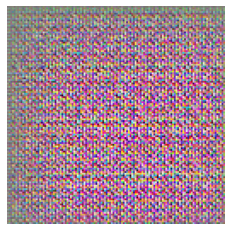

In [50]:
ruido = np.random.normal(0,1,100)
ruido =np.array([ruido])
print(ruido.shape)

resultado = generador.predict(ruido)
resultado = resultado*127.5 + 127.5
resultado = np.ndarray.astype(resultado, np.uint8)

plt.imshow(resultado.reshape(128,128,3))
plt.axis('off')
plt.show()

Por lo que se ve, no hay avance a simple vista y por tanda de entrenamiento tarda 48 s (a 5000 epocas tardaria 66 dias) vamos a provar otra cosa